In [ ]:
# Display the avg location of a particular structure in two shape matched datasets

In [ ]:
!date
!pwd

In [1]:
import os
import sys
import importlib
import concurrent
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
from skimage import io as skio
import matplotlib.pyplot as plt
from aicscytoparam import cytoparam
from aicsshparam import shtools, shparam
from aicsimageio import AICSImage
from aicsimageio.writers import OmeTiffWriter
from cvapipe_analysis.tools import io, viz, general, controller, shapespace, plotting

sys.path.insert(1, '../tools')
import common

In [2]:
# Controller form cvapipe_analysis
path_config = Path("/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/")
config = general.load_config_file(path_config)
control = controller.Controller(config)
device = io.LocalStagingIO(control)
df = device.load_step_manifest("preprocessing")
print(df.shape, control.get_staging())

(202847, 1290) /allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/local_staging_variance


In [3]:
space = shapespace.ShapeSpace(control)
space.execute(df)

In [4]:
# local_staging_variance_edges is generated by using the output dataframe from the
# mapping process to filter out not matched cells from the full dataset.
path_cvapipe = Path(control.get_staging()).parent
datasets = {
    "M1M2": {
        "control": f"{path_cvapipe}/local_staging_variance_m1m2",
        "perturbed": f"{path_cvapipe}/local_staging_m1m2"
    },
    "M3": {
        "control": f"{path_cvapipe}/local_staging_variance_m3",
        "perturbed": f"{path_cvapipe}/local_staging_m3"
    }}

In [5]:
smapper = shapespace.ShapeSpaceMapper(space, output_folder="./")
smapper.use_full_base_dataset()
smapper.set_make_plots_off()
smapper.set_distance_threshold(1e10)
smapper.map(datasets)
df_map = smapper.result
df_map.head()

	M1M2 loaded. (2201, 1255)
	M3 loaded. (981, 1255)


NUC_MEM_PC1  NUC_MEM_PC2  NUC_MEM_PC3  \
dataset structure_name CellId                                          
M1M2    AAVS1          469472    -0.358641     1.887517     0.376298   
                       470002     0.075833     3.041962    -0.783784   
                       470727    -0.351966     1.942956    -0.422845   
                       474704    -0.276548     1.796619     0.101165   
                       475504     0.288828     3.016868     0.019000   

                               NUC_MEM_PC4  NUC_MEM_PC5  NUC_MEM_PC6  \
dataset structure_name CellId                                          
M1M2    AAVS1          469472    -1.513126     2.709623    -1.654536   
                       470002     0.410269     0.088055     0.322870   
                       470727     0.048888     0.408484     1.045099   
                       474704    -0.623875     2.508765     0.055692   
                       475504     1.033316     0.827951     1.793017   

                               NUC_MEM_PC7  NUC_MEM_PC8      Dist  SelfDist  \
dataset structure_name CellId                                                 
M1M2    AAVS1          469472     0.489677    -0.109667  1.639031       NaN   
                       470002    -0.033257    -1.008833  1.335755       NaN   
                       470727    -1.589473     0.045533  0.768158       NaN   
                       474704    -3.708932    -2.758337  2.461051       NaN   
                       475504    -1.163779    -1.885776  1.985920       NaN   

                               NNCellId  Match   M1M2     M3  
dataset structure_name CellId                                 
M1M2    AAVS1          469472    517666   True  False  False  
                       470002    953698   True  False  False  
                       470727    466577   True  False  False  
                       474704    623851   True  False  False  
                       475504    976028   True  False  False

### Loading and voxelizing matched shape

In [6]:
parameterization = {}
for dsname in datasets.keys():
    nisos = control.get_number_of_interpolating_points()
    inner_alias = control.get_inner_most_alias_to_parameterize()
    fname = f"avgshape/{dsname}_{inner_alias}_base_matched.vtk"
    inner_mesh = device.read_vtk_polydata(fname)
    outer_alias = control.get_outer_most_alias_to_parameterize()
    fname = f"avgshape/{dsname}_{outer_alias}_base_matched.vtk"
    outer_mesh = device.read_vtk_polydata(fname)
    domain, origin = cytoparam.voxelize_meshes([outer_mesh, inner_mesh])
    coords_param, coeffs_centroid = cytoparam.parameterize_image_coordinates(
        seg_mem=(domain>0).astype(np.uint8),
        seg_nuc=(domain>1).astype(np.uint8),
        lmax=control.get_lmax(), nisos=[nisos, nisos]
    )
    coeffs_mem, centroid_mem, coeffs_nuc, centroid_nuc = coeffs_centroid
    coords_param += np.array(centroid_nuc).reshape(3, 1, 1)-np.array(centroid_mem).reshape(3, 1, 1)
    
    domain_nuc = (255*(domain>1)).astype(np.uint8)
    domain_mem = (255*(domain>0)).astype(np.uint8)
    
    parameterization[dsname] = {
        "domain": domain,
        "domain_nuc": domain_nuc,
        "domain_mem": domain_mem,
        "coords_param": coords_param
    }

### Control and Device for each shape matched dataset (control and perturbed)

In [7]:
importlib.reload(common)

<module 'common' from '/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/local_staging_notebooks/FigureMitosis/../tools/common.py'>

### Load and aggregate representations

In [8]:
conditions = ["control", "perturbed"]
genes = ["LMNB1", "HIST1H2BJ", "TOMM20", "TUBA1B"]
namemap = {"control": "base", "perturbed": dsname}

In [71]:
data = {}
for dsname in datasets.keys():
    
    data[dsname] = {}
    for gene in genes:
        
        data[dsname][gene] = {}
    
        dsmanagers = common.setup_cvapipe_for_matched_dataset(config, datasets[dsname])

        df_gene = df_map.loc[(dsname, gene)]

        CellIds_pt = df_gene.index.values
        CellIds_ct = df_gene.NNCellId.unique()

        dev_ct, dev_pt = [dsmanagers[q]["device"] for q in conditions]
        
        reps_ct = common.get_all_norm_parameterized_intensity_of_seg_channel(CellIds_ct, dev_ct)
        reps_pt = common.get_all_norm_parameterized_intensity_of_seg_channel(CellIds_pt, dev_pt)
        
        rep_avg_ct = reps_ct.mean(axis=0)
        rep_avg_pt = reps_pt.mean(axis=0)
        
        data[dsname][gene][conditions[0]] = rep_avg_ct
        data[dsname][gene][conditions[1]] = rep_avg_pt

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

### Morphing aggregatate representation into matched shape

In [72]:
instances = {}
for gene in genes:
    instances[gene] = []
    for dsname, cond in zip([k for k in data.keys()]*2, [c for c in conditions for i in range(2)]):
        rep = data[dsname][gene][cond]
        morphed = cytoparam.morph_representation_on_shape(
            img=parameterization[dsname]["domain"],
            param_img_coords=parameterization[dsname]["coords_param"],
            representation=rep
        )
        morphed /= morphed.sum()
        domain_nuc = parameterization[dsname]["domain_nuc"]
        domain_mem = parameterization[dsname]["domain_mem"]
        instances[gene].append(np.stack([domain_nuc, domain_mem, morphed], axis=0))

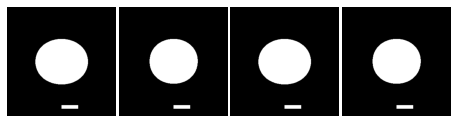

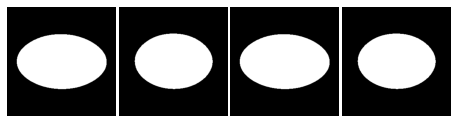

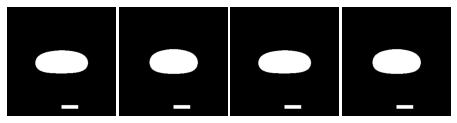

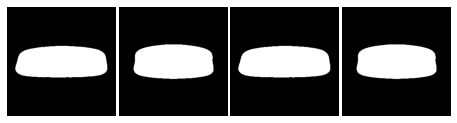

In [73]:
mode = {
    "nuc": "center_nuc",
    "mem": "center_nuc",
    "gfp": "center_nuc"
}
gene = genes[0]
args = {"gridspec_kw": {"hspace": 0, "wspace": 0}, "sharex": True, "sharey": True}
ni = len(instances[gene])
for orient in ["z", "y"]:
    for alias in ["nuc", "mem"]:
        fig, axs = plt.subplots(1, ni, figsize=(2*ni, 2), **args)
        for ax, instance in zip(axs, instances[gene]):
            ax.axis("off")
            proj = common.Projector(instance)
            proj.set_projection_mode(ax=orient, mode=mode)
            proj.project_on(alias=alias, ax=ax, scale_bar={"pixel_size":0.108, "length":5})
            plt.savefig(f"FigureMitosis2_{alias}_{orient}.png", dpi=150)
        plt.show()

In [78]:
# Calculating min max presets:
df_presets = []
pcts = {"LMNB1": [0, 90], "HIST1H2BJ": [0, 90], "TOMM20": [0, 80], "TUBA1B": [0, 95]}
for gene in genes:
    vmin, vmax = common.Projector.get_shared_gfp_range(instances[gene], pcts[gene])
    df_presets.append({"gene": gene, "vmin": vmin, "vmax": vmax})
df_presets = pd.DataFrame(df_presets).set_index("gene")
df_presets

,vmin,vmax
gene,,
LMNB1,0.0,1.933746e-06
HIST1H2BJ,0.0,1.823160e-06
TOMM20,0.0,9.108169e-07
TUBA1B,0.0,1.693061e-06


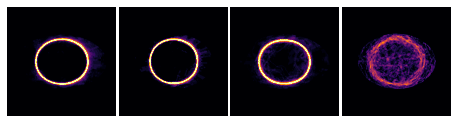

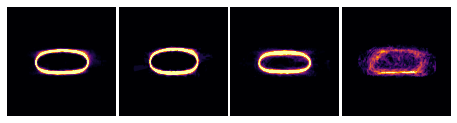

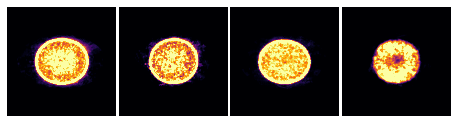

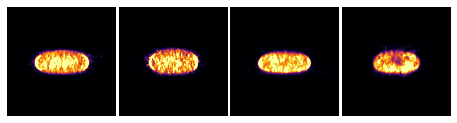

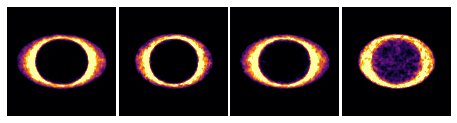

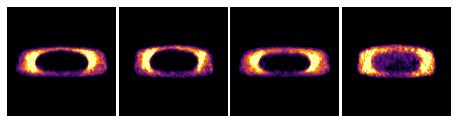

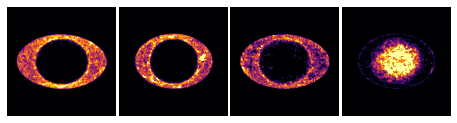

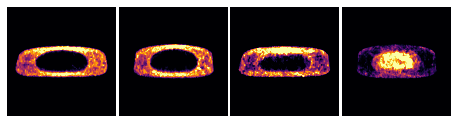

In [79]:
for gene in genes:
    ni = len(instances[gene])
    for orient in ["z", "y"]:
        fig, axs = plt.subplots(1, ni, figsize=(2*ni, 2), **args)
        for ax, instance in zip(axs, instances[gene]):
            ax.axis("off")
            proj = common.Projector(instance)
            proj.set_projection_mode(ax=orient, mode=mode)
            view = proj.project_on(alias="gfp", ax=ax, scale_bar={"pixel_size":0.108, "length":5})
        view.set_clim(df_presets.at[gene, "vmin"], df_presets.at[gene, "vmax"])
        plt.savefig(f"FigureMitosis2_{gene}_gfp_{orient}.png", dpi=150)
        plt.show()